In [1]:
import os
import cv2
import zipfile
import random
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import activations

In [2]:
files = [file for file in os.listdir("tmp/Pistachio")]

In [3]:
files

['Kirmizi_Pistachio', 'Siirt_Pistachio']

In [4]:
def load_images_from_folder(folder):
    files = [file for file in os.listdir(folder)]
    output = dict()
    
    for file in files:
        print(folder + "/" + file)
        images = []
        
        for filename in os.listdir(folder + "/" + file):
            img = cv2.imread(os.path.join(folder + "/" + file, filename))
            img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if img is not None:
                images.append(img)
        output[file] = (np.array(images) / 255).reshape([-1, 64, 64, 1])
    
    return output

In [5]:
folder = "tmp/Pistachio"

In [6]:
dataset = load_images_from_folder(folder)

tmp/Pistachio/Kirmizi_Pistachio
tmp/Pistachio/Siirt_Pistachio


In [7]:
dataset[list(dataset.keys())[0]][0][32][32]

array([0.84705882])

In [8]:
features = dataset[list(dataset.keys())[0]]
counter = 0
labels = np.full((dataset[list(dataset.keys())[0]].shape[0], 1), counter)
for x in list(dataset.keys())[1:]:
    counter += 1
    features = np.concatenate((features, dataset[x]), axis=0)
    labels = np.concatenate((labels, np.full((dataset[x].shape[0], 1), counter)))

print(features.shape)
print(labels.shape)

(2148, 64, 64, 1)
(2148, 1)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [10]:
data_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(1024)

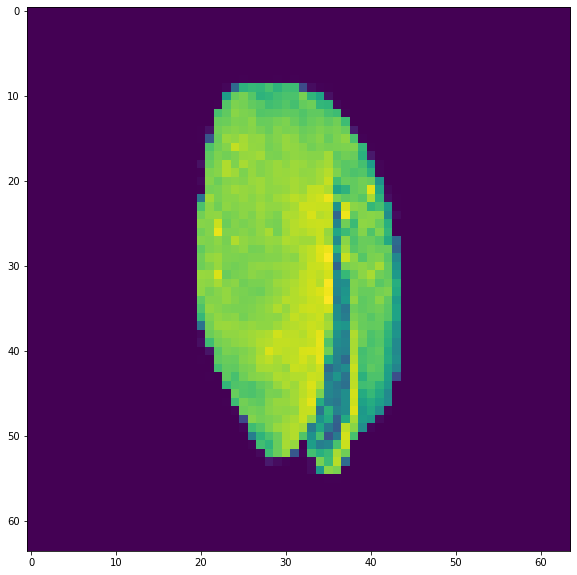

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(dataset[list(dataset.keys())[0]][0])
plt.show()

In [12]:
def make_convolutional_model(activation_functions, type_of_pooling, inp_shape, alpha=0.2, num_classes=2):
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), activation=activation_functions["hidden layer"], padding='same', input_shape=inp_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), activation=activation_functions["hidden layer"], padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), activation=activation_functions["hidden layer"], padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), activation=activation_functions["hidden layer"], padding='same'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation=activation_functions["hidden layer"]))
    model.add(layers.Dropout(alpha))
    
    if activation_functions["output layer"] == activations.softmax:
        model.add(layers.Dense(num_classes, activation=activation_functions["output layer"]))
    else:
        model.add(layers.Dense(num_classes - 1, activation=activation_functions["output layer"]))
    
    return model

In [13]:
activation_functions = {
  "hidden layer": activations.relu,
  "output layer": activations.softmax,
}

In [14]:
model = make_convolutional_model(activation_functions, "max", [64, 64, 1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 128)         204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

In [15]:
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.00025)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
scc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=opt_adam, loss=scc, metrics=['accuracy'])

In [16]:
history = model.fit(data_train, epochs=300, validation_data=(X_test, y_test))

Epoch 1/300
2/2 [==============================] - 2s 937ms/step - loss: 0.6929 - accuracy: 0.5250 - val_loss: 0.6911 - val_accuracy: 0.5674
Epoch 2/300
2/2 [==============================] - 2s 765ms/step - loss: 0.6906 - accuracy: 0.5757 - val_loss: 0.6886 - val_accuracy: 0.5674
Epoch 3/300
2/2 [==============================] - 2s 749ms/step - loss: 0.6879 - accuracy: 0.5751 - val_loss: 0.6853 - val_accuracy: 0.5674
Epoch 4/300
2/2 [==============================] - 2s 741ms/step - loss: 0.6844 - accuracy: 0.5780 - val_loss: 0.6807 - val_accuracy: 0.5674
Epoch 5/300
2/2 [==============================] - 1s 704ms/step - loss: 0.6794 - accuracy: 0.5844 - val_loss: 0.6744 - val_accuracy: 0.5814
Epoch 6/300
2/2 [==============================] - 2s 789ms/step - loss: 0.6732 - accuracy: 0.5885 - val_loss: 0.6658 - val_accuracy: 0.6116
Epoch 7/300
2/2 [==============================] - 1s 695ms/step - loss: 0.6644 - accuracy: 0.6065 - val_loss: 0.6538 - val_accuracy: 0.6302
Epoch 8/300
2

In [17]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

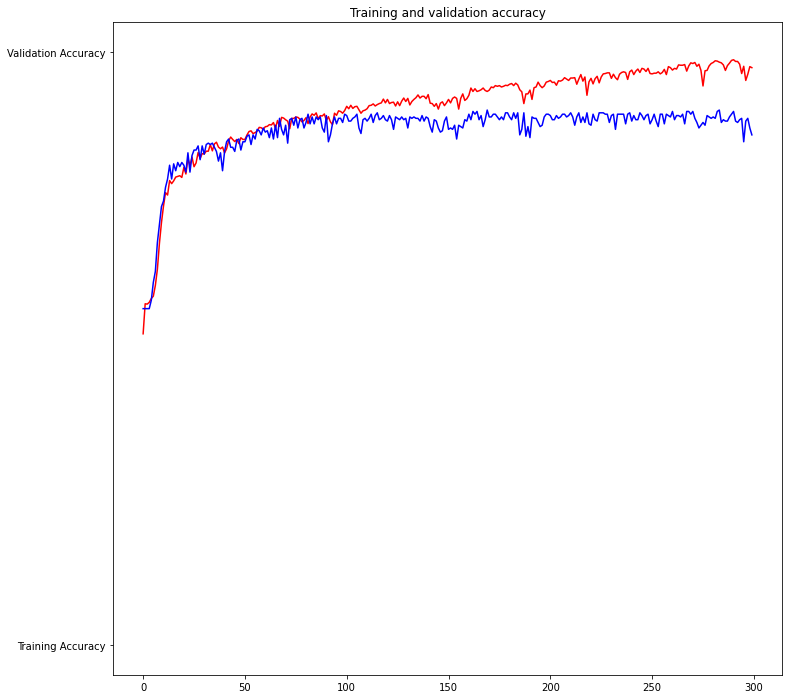

In [19]:
plt.figure(figsize=(12, 12))
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()

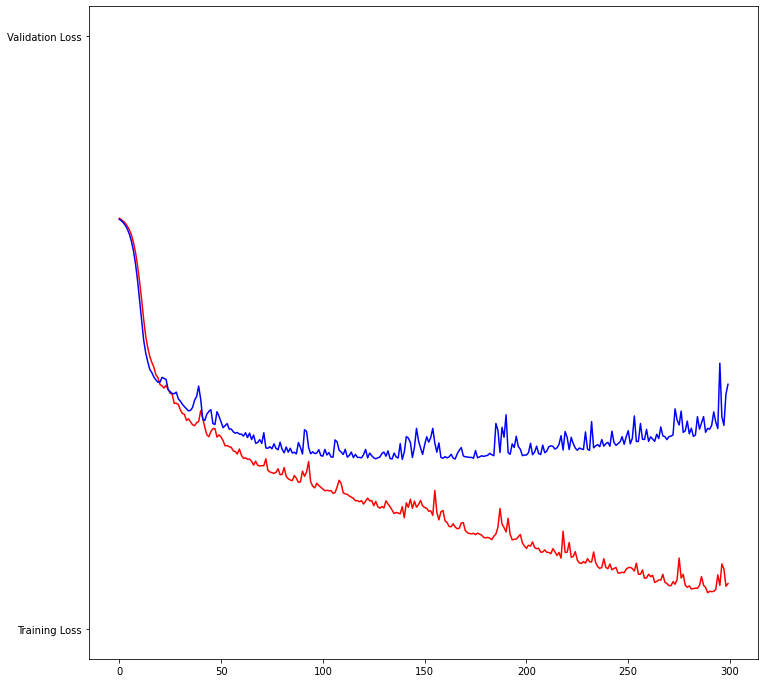

In [20]:
plt.figure(figsize=(12, 12))
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()